# XAI - Captum Tutorials

In [ ]:
!pip install captum torch torchvision

In [ ]:
# Initial imports
import numpy as np
import torch

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients, GradientShap, Occlusion, LayerGradCam
from captum.attr import visualization as viz
from captum.attr import NoiseTunnel

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Tutorial 1. Gradient-based attribution: **Integrated Gradient**
Integrated gradients represents the integral of gradients with respect to inputs along the path from a given baseline to input. Here, Integrated Gradients along the i-th dimension of input X. Alpha is the scaling coefficient.
$$
\operatorname{IntegratedGrads~}_i(x)::=\left(x_i-x_i^{\prime}\right) \times \int_{\alpha=0}^1 \frac{\partial F\left(x^{\prime}+\alpha \times\left(x-x^{\prime}\right)\right)}{\partial x_i} d \alpha
$$

- original paper: https://arxiv.org/abs/1703.01365

#### 1) Loading the model and the dataset

Loads pretrained Resnet model and sets it to eval mode

In [ ]:
model = models.resnet18(pretrained=True)
model = model.eval()

Downloads the labels of ImageNet dataset and an web image, and reads them into the memory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/xai"

In [ ]:
!wget -P "/content/drive/My Drive/xai" https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
!wget -nd -r -P "/content/drive/My Drive/xai" -A jpeg,jpg,bmp,gif,png https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/YellowLabradorLooking_new.jpg/640px-YellowLabradorLooking_new.jpg

Refers to ImageNet class index

In [ ]:
import json
labels_path = '/content/drive/My Drive/xai/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)
idx_to_labels

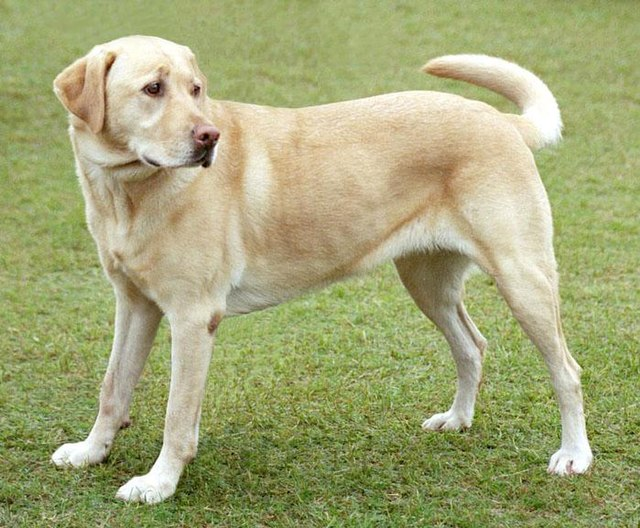

In [ ]:
img = Image.open('/content/drive/My Drive/xai/640px-YellowLabradorLooking_new.jpg')
img

Transform image to tensor by defining tensor transformers and normalizing functions for the image.

In [ ]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

#### 2) Create an IntegratedGradient object

Let's compute attributions using Integrated Gradients. <br>
 - Integrated gradients computes the integral of the gradients of the output of the model for the predicted class ```TARGET_LABEL_IDX``` with respect to the input image pixels along the path from the ```ZERO```(black image) to our input image.

In [ ]:
TARGET_LABEL_IDX = 208  # 'Labrador_retriever' class
ZERO = torch.zeros(input.shape)

ig = IntegratedGradients(model)
attributions_ig = ig.attribute(input,
                               target=TARGET_LABEL_IDX,
                               n_steps=20,
                               baselines=ZERO,)

#### 3) Visualize the attributions
Visualize the attributions with Captum viz method.

In [ ]:
attributions_ig = np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0))
input_img = np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0))

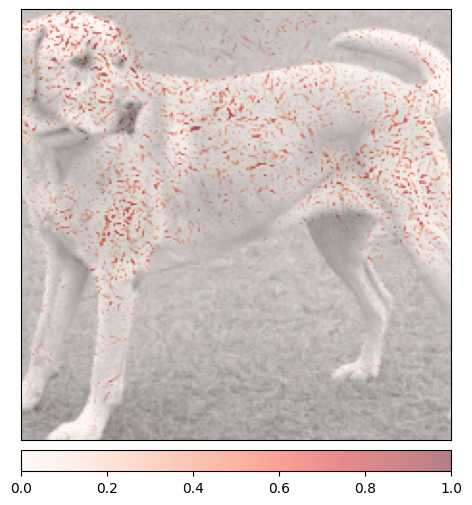

In [ ]:
_ = viz.visualize_image_attr(attributions_ig,
                              input_img,
                              method="blended_heat_map",
                              cmap="Reds",
                              show_colorbar=True,
                              sign="positive",
                              outlier_perc=5)

## Tutorial 2. **SmoothGrad** for Robust Attribution
Noise tunnel computes attribution multiple times, adding Gaussian noise to the input each time, and combines the calculated attributions.

c.f., Improved methods with Noise Tunnel <br>
- 1. SmoothGrad
$$
\hat{M}_c(x)=\frac{1}{n} \sum_1^n M_c\left(x+\mathcal{N}\left(0, \sigma^2\right)\right)
$$
- 2. SmoothGrad-Squared (less noisy)
$$
\hat{M}_c(x)=\frac{1}{n} \sum_1^n \sqrt{M_c\left(x+\mathcal{N}\left(0, \sigma^2\right)\right)}
$$
- 3. VarGrad (variance version, less noisy)
$$
\tilde{M}_c(x)=\frac{1}{n} \sum_{k=1}^n\left\{M_c\left(x+\mathcal{N}\left(0, \sigma^2\right)\right)\right\}^2-\left\{\hat{M}_c(x)\right\}^2
$$
<br>
- Examples of SmoothGrad Variants
![SmoothGrad Variants](https://erdem.pl/static/4ef66c779d5f048acd881398bbb6a0dc/29114/noise_tunnel_options.png "SmoothGrad Variants")

- original papers: <br>
(SmoothGrad) https://arxiv.org/abs/1706.03825<br>
(VarGrad) https://arxiv.org/abs/1810.03307


#### 1) With Captum _NoiseTunnel_ method

Noise tunnel smoothens the attributions across ```nt_samples``` noisy samples using ```smoothgrad_sq``` technique. ```smoothgrad_sq``` represents the mean of the squared attributions across ```nt_samples``` samples.

In [ ]:
nt = NoiseTunnel(ig)
attributions_ig_nt = nt.attribute(input,
                                  nt_samples=10,
                                  nt_type='smoothgrad_sq',
                                  stdevs=1.0,
                                  target=TARGET_LABEL_IDX)

In [ ]:
attributions_ig_nt = np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0))
input_img = np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


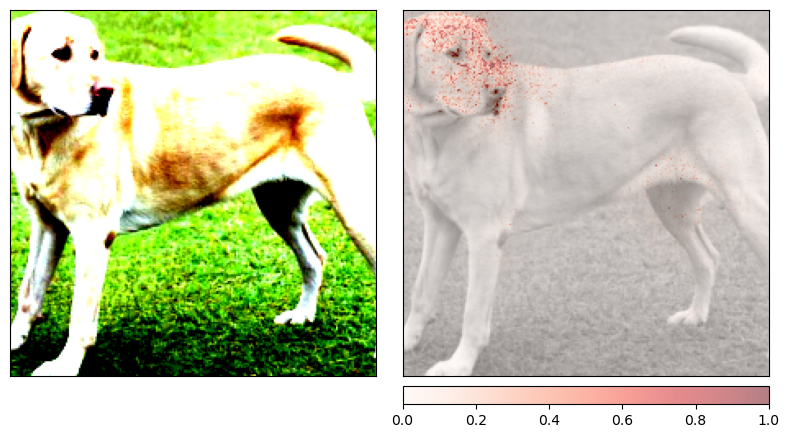

In [ ]:
_ = viz.visualize_image_attr_multiple(attributions_ig_nt,
                                      input_img,
                                      methods=["original_image", "blended_heat_map"],
                                      cmap="Reds",
                                      show_colorbar=True,
                                      signs=["all", "positive"],
                                      outlier_perc=5)

#### 2) In a manual way

In [ ]:
nt_samples=10
attribution = 0
for _ in range(nt_samples):
    noise = torch.FloatTensor(input.shape).uniform_(-1, 1)
    noisy_input = input+noise
    attribution += ig.attribute(noisy_input,
                                baselines=ZERO,
                                n_steps=10,
                                target=TARGET_LABEL_IDX,).squeeze().cpu().detach().numpy()
attributions_ig_smooth = attribution/nt_samples

In [ ]:
attributions_ig_smooth = np.transpose(attributions_ig_smooth, (1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


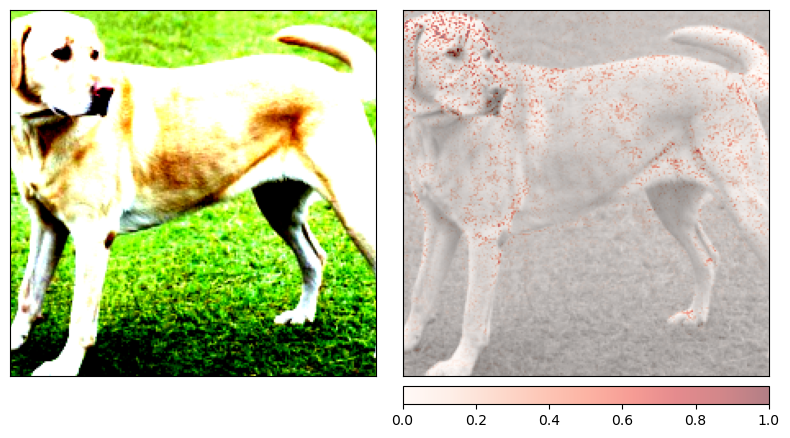

In [ ]:
_ = viz.visualize_image_attr_multiple(attributions_ig_smooth,
                                      input_img,
                                      methods=["original_image", "blended_heat_map"],
                                      cmap="Reds",
                                      show_colorbar=True,
                                      signs=["all", "positive"],
                                      outlier_perc=5)

## 3. Perturbation-based attribution: **Occlusion**

Occlusion method is estimating which areas of the image are critical for the model's decision by occluding input regions and quantifying how the decision changes.
- original paper: https://arxiv.org/abs/1311.2901

We run **a sliding window of size 15x15** (defined via ```sliding_window_shapes```) with **a stride of 8** along both image dimensions (a defined via ```strides```). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via ```baselines```).

**Note**: this computation might take more than one minute to complete, as the model is evaluated at every position of the sliding window.

In [ ]:
oc = captum.attr.Occlusion(model)
attributions_occ = oc.attribute(input,
                                sliding_window_shapes=(3, 15, 15),
                                strides = (3, 8, 8),
                                target=TARGET_LABEL_IDX,
                                baselines=0)

In [ ]:
attributions_occ = np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


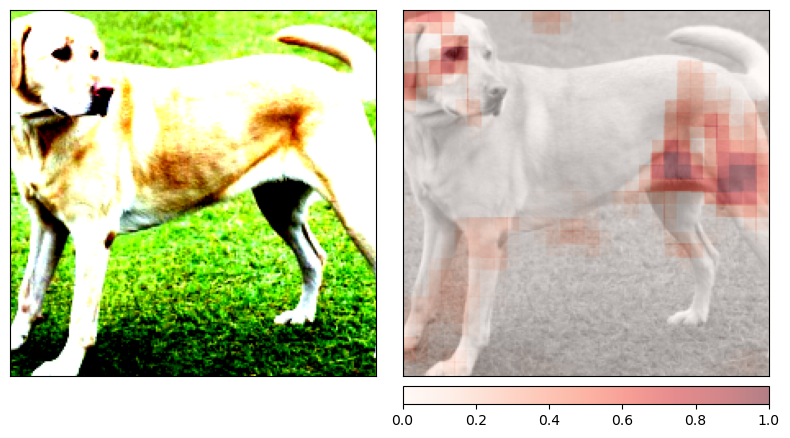

In [ ]:
_ = viz.visualize_image_attr_multiple(attributions_occ,
                                      input_img,
                                      methods=["original_image", "blended_heat_map"],
                                      cmap="Reds",
                                      show_colorbar=True,
                                      signs=["all", "positive"],
                                      outlier_perc=5)

Let's try to Occlude the image using **a larger sliding window, 60x60**:

In [ ]:
oc = Occlusion(model)
attributions_occ = oc.attribute(input,
                                sliding_window_shapes=(3, 60, 60),
                                strides = (3, 50, 50),
                                target=TARGET_LABEL_IDX,
                                baselines=0)

In [ ]:
attributions_occ = np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


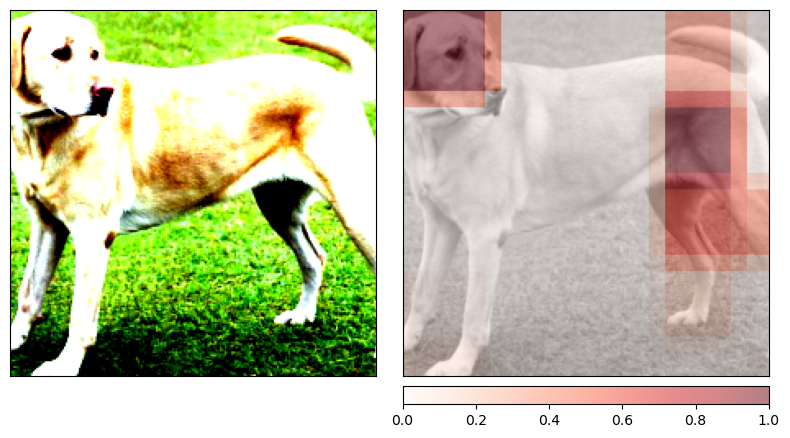

In [ ]:
_ = viz.visualize_image_attr_multiple(attributions_occ,
                                      input_img,
                                      methods=["original_image", "blended_heat_map"],
                                      cmap="Reds",
                                      show_colorbar=True,
                                      signs=["all", "positive"],
                                      outlier_perc=5)

## Tutorial 4. Extension: **Semantic Segmentation** with Captum
Here, We apply Captum to semantic segmentation task, to understand what pixels and regions contribute to the labeling of a particular class.

- Explaining classification models: <br>
The output has a single scalar score for a target class, such as a target logit.
![Explaining classification models](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0130140.g001&type=large "Explaining classification models")

- Explaining semantic segmentation models: <br>
The output has **2D scores(logit)** for a target class. (cannot apply Captum directly!)
![Explaining semantic segmentation models](https://i.ibb.co/grq2zrR/image.png "Explaining semantic segmentation models")

#### 1) Loading the model and the dataset

Loads the pre-trained segmentation model from torchvision, which is trained on a subset of COCO Train 2017 and define input preprocessing transforms.


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
fcn = models.segmentation.fcn_resnet101(pretrained=True).to(device).eval()

Obtains an image from the COCO training set to evaluate and interpret the segmentation model.

In [ ]:
!wget -nv --directory-prefix="/content/drive/My Drive/xai" https://farm8.staticflickr.com/7301/8862358875_eecba9fb10_z.jpg

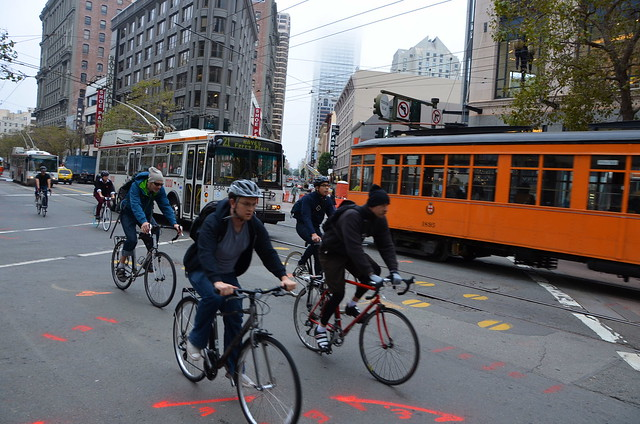

In [ ]:
img = Image.open("/content/drive/My Drive/xai/8862358875_eecba9fb10_z.jpg")
img

Input image preprocessing

In [ ]:
preprocessing = transforms.Compose([transforms.Resize(640),
                                    transforms.ToTensor()])
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])
input = normalize(preprocessing(img))

Run the FCN model visualize the image segmentation output.

In [ ]:
input = input.unsqueeze(0).to(device)
input.requires_grad = True
output = fcn(input)['out']
out_max = torch.argmax(output, dim=1, keepdim=True)

We define a few helper methods to visualize segmentation results. (Source: https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/)

In [ ]:
def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (255, 255, 255),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (255, 127, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

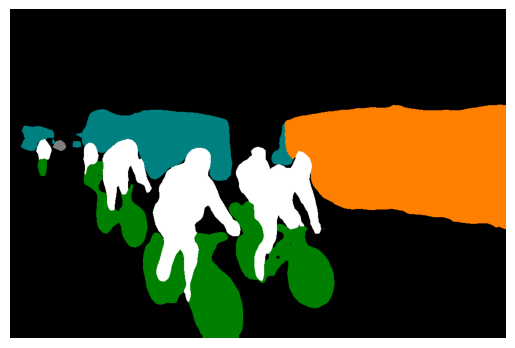

In [ ]:
rgb = decode_segmap(out_max.detach().cpu().squeeze().numpy())
plt.imshow(rgb)
plt.axis('off')
plt.show()

We see that the segmentation model has identified regions including humans, bicicyles, trucks, and cars. We will now interpret the model using Captum to understand what pixels contribute to these predictions.

#### 2) Define a wrapper for segmentation model

In order to apply input attribution method, we need to transform the multi-pixel segmentation outputs to a single scalar score.

- **Aggregation Wrapper:** Simply summing each output channel. This approach is simple to implement, but could result in misleading attribution when a pixel is not predicted as a certain class but still has a high score for that class.
- **Masked Aggregation Wrapper:** Based on above, summing only the scores corresponding to pixels that are predicted to be a particular class (argmax class) and attribute with respect to this sum. <br>

We define a wrapper function that performs this, and can use this wrapper for attribution instead of the original model.

In [ ]:
def aggregation_wrapper(input):
    return fcn(input)['out'].sum(dim=(2,3))

def masked_aggegation_wrapper(input):
    model_out = fcn(input)['out']
    selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
    return (model_out * selected_inds).sum(dim=(2,3))

#### 3) Create a GradCAM attribution object

Computes GradCAM attributions by providing the input and the desired target segmentation class (between 0 and 20 in COCO), which is the index of the output. Target class indices are described in the ```decode_segmap``` helper method.

In [ ]:
target=6 # 'bus'
lgc = LayerGradCam(masked_aggegation_wrapper, fcn.backbone.layer4[2].conv3)
attribution_gc = lgc.attribute(input, target=target)

#### 4) Visualize

Upsamples the layer GradCAM attributions to match the input size in order to understand this better by overlaying it on the original image.

In [ ]:
upsampled_gc_attr = torch.nn.functional.upsample(attribution_gc,
                                                 size=input.shape[2:])

In [ ]:
upsampled_gc_attr = upsampled_gc_attr[0].cpu().permute(1,2,0).detach().numpy()
input_img = np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


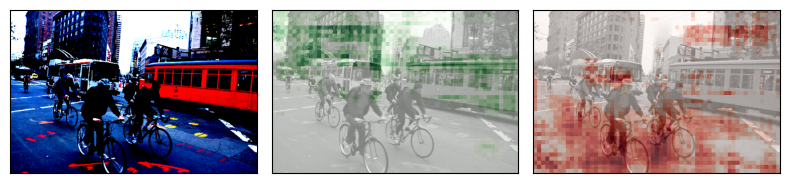

(<Figure size 800x600 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [ ]:
viz.visualize_image_attr_multiple(upsampled_gc_attr,
                                  original_image=input_img,
                                  signs=["all", "positive", "negative"],
                                  methods=["original_image", "blended_heat_map","blended_heat_map"])


#### References
Soyeon Kim
(SAILab, KAIST AI | soyeon.k@kaist.ac.kr) <br>
https://xai.kaist.ac.kr/Tutorial/2023/
